In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import BaggingClassifier,VotingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import datetime
import time
% matplotlib inline

/Users/jonathanbeatty/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/Users/jonathanbeatty/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
UsageError: Line magic function `%` not found.


## Below I am reading in two .csv's ive created from previous scrapinmg, I tried to bring in 1000 more posts but I will also be removing duplicates.

In [6]:
df = pd.read_csv('/Users/jonathanbeatty/DSI-US-5/project-3/4000_model_use! 2018-09-06 12:48:28.csv')

In [7]:
df_small = pd.read_csv('/Users/jonathanbeatty/DSI-US-5/project-3/third_scrape_model_use! 2018-09-06 12:46:03.csv')

In [8]:
df_small.shape

(1993, 3)

## I went ahead and filled the NaN values from importing in the description section with simply an empty string. I am not even using the descriptions in my main model so it shouldnt affect accuracy.

In [9]:
df = df.fillna('')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3976 entries, 0 to 3975
Data columns (total 3 columns):
Title          3976 non-null object
Description    3976 non-null object
Subreddit      3976 non-null int64
dtypes: int64(1), object(2)
memory usage: 93.3+ KB


In [10]:
df_small = df_small.fillna('')
df_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1993 entries, 0 to 1992
Data columns (total 3 columns):
Title          1993 non-null object
Description    1993 non-null object
Subreddit      1993 non-null int64
dtypes: int64(1), object(2)
memory usage: 46.8+ KB


## After cleaning my two dataframes I concat them together, giving me a large dataframe but unfortunately the sad part is to come.

In [11]:
df_model = pd.concat([df, df_small])

df_model.shape

(5969, 3)

In [12]:
df_model.head()

,Title,Description,Subreddit
0,AskScience Panel of Scientists XIX,**Please read this entire post carefully and f...,1
1,AskScience AMA Series: We're compression exper...,"Hi, we are Dmitri Pavlichin (postdoc fellow) a...",1
2,When sign language users are medically confuse...,"Additionally, in hearing people, things like a...",1
3,"When an avocado is not ripe, are the fats and ...","Here I am sitting with a bag full of avocados,...",1
4,Does the ISS need to constantly make micro cou...,I know the crew can't make the ISS plummet to ...,1


## Here I am dropping all of the duplicate rows from the title column since I want a clean model to test with. This drops our Data substantially but I think it will still be enough information to make our predictions

In [13]:
df_model = df_model.drop_duplicates(['Title'])
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2173 entries, 0 to 1835
Data columns (total 3 columns):
Title          2173 non-null object
Description    2173 non-null object
Subreddit      2173 non-null int64
dtypes: int64(1), object(2)
memory usage: 67.9+ KB


## Saving my final model with no duplicates for further use

In [14]:
now = str(datetime.datetime.now())[:19]

filename = f'Final_model_no_dups {now}.csv'
filename

df_model.to_csv(filename, index = False)

In [15]:
df_model['Subreddit'].value_counts(normalize=True)

0    0.504832
1    0.495168
Name: Subreddit, dtype: float64

## Now im beginning by doing my basic train test split so I can start running this model through basic models before we get deeper into gridserch/pipeline models

In [16]:
X = df_model['Title']
y = df_model['Subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state =42, stratify=y)

In [17]:
cv = CountVectorizer(stop_words='english')
cv.fit(X_train)

X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

In [18]:
train_set = pd.DataFrame(X_train_cv.todense(), columns =cv.get_feature_names())

train_set['Subreddit'] = y_train.values

In [19]:
features = [col for col in train_set.columns if col != 'Subreddit']
X_1 = train_set[features] 
y_1 = train_set['Subreddit']

In [20]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1)

In [21]:
# I used this code to make a new stopwords column but since None seems to be the consensus winner for a feature I took this out
# new_stopwords = ['does', 'did', 'would']
# stopwords.extend(new_stopwords)
# stopwords.open

In [22]:
train_set.sum().sort_values(ascending=False)[:50]

Subreddit    807
does         280
star         117
like          98
did           97
mcu           90
wars          74
marvel        72
earth         62
just          62
dc            59
general       55
people        51
man           49
different     48
work          43
time          43
harry         42
water         42
know          41
use           39
space         38
humans        38
potter        36
war           36
change        35
universe      35
infinity      34
make          32
human         32
way           31
world         31
body          30
light         30
mass          29
sun           29
able          28
power         28
happen        28
species       27
possible      27
trek          26
black         26
happens       26
magic         26
actually      25
energy        25
didn          25
force         24
batman        24
dtype: int64

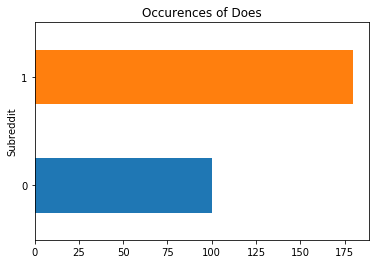

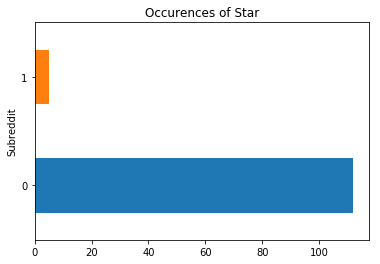

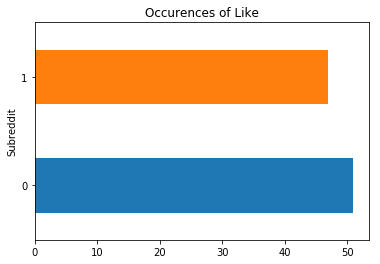

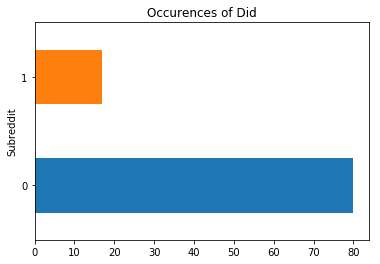

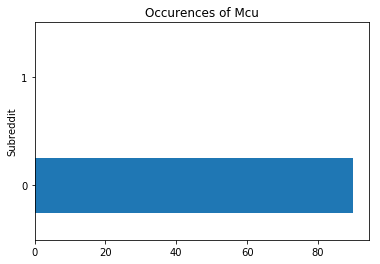

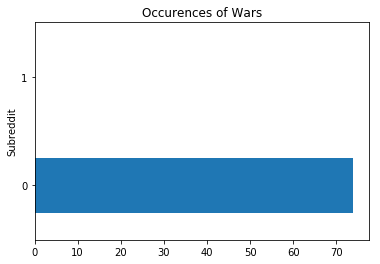

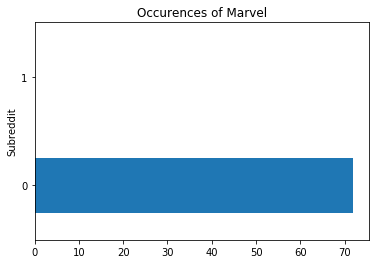

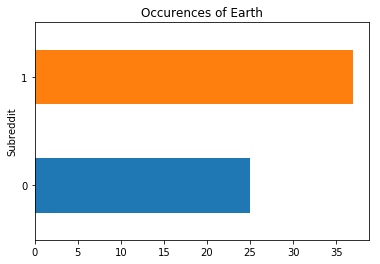

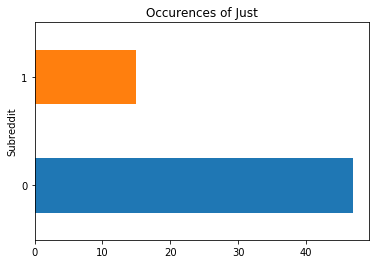

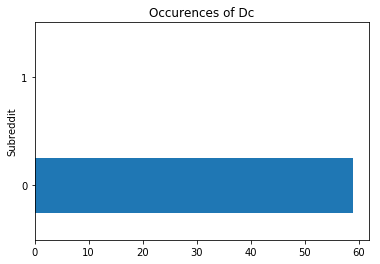

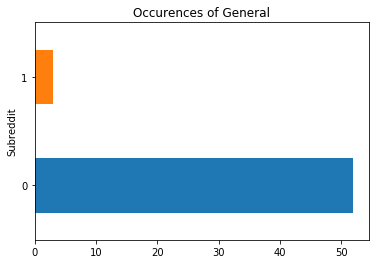

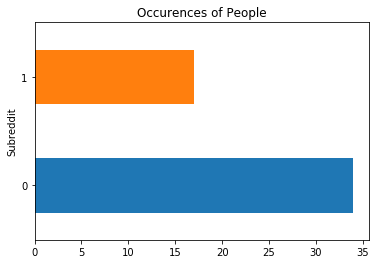

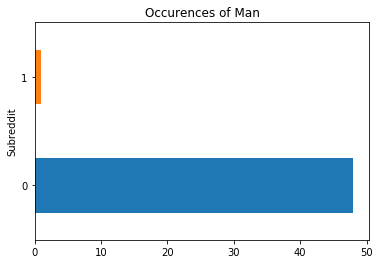

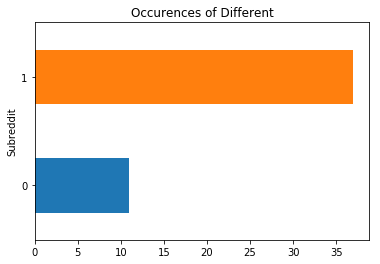

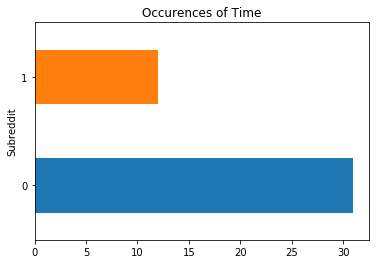

In [23]:
def plot_word_from_groupby(word, df=train_set):
    train_set.groupby('Subreddit').sum()[word].plot(kind='barh')
    plt.title(f'Occurences of {word.title()}')
    plt.show()

words = list(train_set.drop('Subreddit',
              axis = 1).sum().sort_values(ascending=False)[:15].index)

for word in words:
    plot_word_from_groupby(word)

## Going to Instantiate a Vader Sentiment Analysis to see if we can get a better read on the datas positive and negative sentiments

In [24]:
sia = SentimentIntensityAnalyzer()

dicts = []

for title in df_model['Title']:
    scores = sia.polarity_scores(title)
    scores['Title'] = title
    dicts.append(scores)

df_vader = pd.DataFrame(dicts)
df_vader = df_vader.drop_duplicates(['Title'])

df_vader.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2173 entries, 0 to 2172
Data columns (total 5 columns):
Title       2173 non-null object
compound    2173 non-null float64
neg         2173 non-null float64
neu         2173 non-null float64
pos         2173 non-null float64
dtypes: float64(4), object(1)
memory usage: 101.9+ KB


In [25]:
df_vader['Subreddit'] = df_model['Subreddit'].values

In [26]:
df_vader.sort_values(by='neg', ascending=False).head(10)

,Title,compound,neg,neu,pos,Subreddit
1905,[Rogue One:A Star Wars Story] How badly was Je...,-0.8625,0.578,0.422,0.0,0
916,What causes dust devils?,-0.5719,0.552,0.448,0.0,1
1396,[MCU]Why Thanos was Wrong!,-0.5255,0.531,0.469,0.0,0
624,How can chemicals cause cancer?,-0.6597,0.524,0.476,0.0,1
1059,[CW Flash] Why have none of the Flash villains...,-0.9062,0.507,0.493,0.0,0
2006,[Starwars] Did Obi-Wan die a virgin?,-0.5994,0.494,0.506,0.0,0
1817,[Star Wars] Did Anakin/Vader resent or hate Ah...,-0.6597,0.474,0.526,0.0,0
1554,[MCU] Infinity War Spoilers inside: question a...,-0.8689,0.471,0.529,0.0,0
1825,[MCU] Why does Doctor Strange fight physically?,-0.5267,0.468,0.532,0.0,0
2053,[Death Note] How would the Death Note kill som...,-0.8625,0.462,0.538,0.0,0


In [27]:
df_vader.sort_values(by='pos', ascending=False).head(10)

,Title,compound,neg,neu,pos,Subreddit
208,How are electronegativity values for elements ...,0.6249,0.000,0.495,0.505,1
1833,[MCU]Do the infinity stones give their wielder...,0.7579,0.000,0.514,0.486,0
158,What makes central Africa so mineral and jewel...,0.7479,0.000,0.524,0.476,1
762,What reduces excitement of materials? Can cert...,0.9388,0.000,0.559,0.441,1
748,Do programs like luminosity actually help incr...,0.7579,0.000,0.571,0.429,1
1595,[Bleach] How is Ichigo so powerful?,0.5598,0.000,0.580,0.420,0
299,Can radiation ever give a positive effect?,0.5574,0.000,0.581,0.419,1
715,How does bark help protect trees from fire?,0.4404,0.189,0.394,0.417,1
197,Why use the ideal gas constant in aqueous solu...,0.6908,0.000,0.584,0.416,1
1490,[DC] Kryptonian-New God hybrid,0.2732,0.000,0.588,0.412,0


# After getting my VADER model set up I wanted to do a quick graph of the general sentiment values for both subreddits combined, to see if there would be a more useful metric to use.

In [28]:
df_vader_no_title = df_vader.drop('Title', axis =1)

df_vader_no_title.head()

,compound,neg,neu,pos,Subreddit
0,0.0000,0.000,1.000,0.000,1
1,0.0000,0.000,1.000,0.000,1
2,-0.5574,0.184,0.751,0.065,1
3,0.0000,0.000,1.000,0.000,1
4,0.0000,0.000,1.000,0.000,1


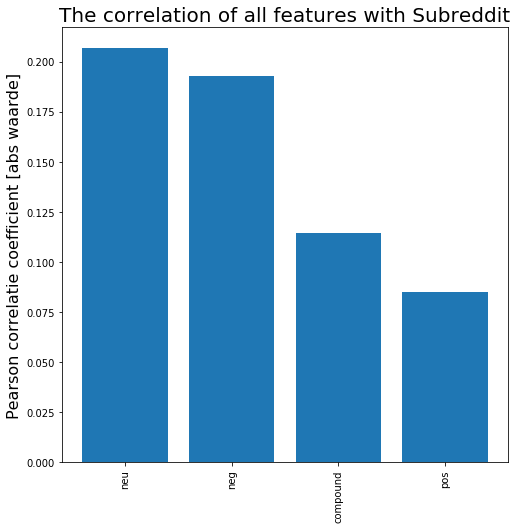

In [29]:
def display_corr_with_col(df, col):
    correlation_matrix = df.corr()
    correlation_type = correlation_matrix[col].copy()
    abs_correlation_type = correlation_type.apply(lambda x: abs(x))
    desc_corr_values = abs_correlation_type.sort_values(ascending=False)
    y_values = list(desc_corr_values.values)[1:]
    x_values = range(0,len(y_values))
    xlabels = list(desc_corr_values.keys())[1:]
    fig, ax = plt.subplots(figsize=(8,8))
    ax.bar(x_values, y_values)
    ax.set_title('The correlation of all features with {}'.format(col), fontsize=20)
    ax.set_ylabel('Pearson correlatie coefficient [abs waarde]', fontsize=16)
    plt.xticks(x_values, xlabels, rotation='vertical')
    plt.show()
 
 
display_corr_with_col(df_vader_no_title, 'Subreddit')

## This is my first initial, simple model using Random Forest Classifier
1. After adding the new stop words my test score improved by 3.5 points on the test data here

In [30]:
rfc = RandomForestClassifier()

rfc.fit(X_train_cv, y_train)

rfc.score(X_train_cv, y_train), rfc.score(X_test_cv, y_test)

(0.992633517495396, 0.8363970588235294)

## I am creating a Dataframe to show the feature importance according to my Random Forest Classifier

In [31]:
df_importance = pd.DataFrame({
    'feature importances': rfc.feature_importances_,
    'words': cv.get_feature_names()
}).set_index('words').sort_values('feature importances', ascending = False)

In [32]:
df_importance.head(25)

,feature importances
words,
marvel,0.032612
star,0.031277
mcu,0.030101
potter,0.018125
dc,0.017325
man,0.016446
general,0.012468
didn,0.011476
wars,0.010630


## Below im going to do a basic Logistic Regression model with the Count Vectorization and  training data from above.

In [33]:
lr = LogisticRegressionCV()
lr.fit(X_train_cv, y_train)

lr.score(X_train_cv, y_train), lr.score(X_test_cv, y_test)

(1.0, 0.8823529411764706)

## As you can see above the basic logistic regression model is actually far outperforming our Random Forest Classifier on the test data, since the training data will always be close to 1 and over fit the Test data score is a much nmore accurate representation of our models strength.

# Below I have brought in some code from this article on scikit learn and classification models. The code is creating a dictionary of my models I want to run a baseline model on and then cast that into a data frame to display my training and test scores. After I ran the required 2 models I want to run a larger range to make sure I wasnt missing any model that was performing very well out of the gate.

In [ ]:
dict_classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Nearest Neighbors": KNeighborsClassifier(),
    "Linear SVM": svm.SVC(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(n_estimators=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=1000),
    "Extra Tree": ExtraTreesClassifier(),
    "Naive Bayes": MultinomialNB(),
    "AdaBoost": AdaBoostClassifier()
}

In [177]:
def batch_classify(X_train, Y_train, X_test, Y_test, no_classifiers = 5, verbose = True):
    """
    This method, takes as input the X, Y matrices of the Train and Test set.
    And fits them on all of the Classifiers specified in the dict_classifier.
    The trained models, and accuracies are saved in a dictionary. The reason to use a dictionary
    is because it is very easy to save the whole dictionary with the pickle module.
    
    Usually, the SVM, Random Forest and Gradient Boosting Classifier take quiet some time to train. 
    So it is best to train them on a smaller dataset first and 
    decide whether you want to comment them out or not based on the test accuracy score.
    """
    
    dict_models = {}
    for classifier_name, classifier in list(dict_classifiers.items())[:no_classifiers]:
        t_start = time.clock()
        classifier.fit(X_train, y_train)
        t_end = time.clock()
        
        t_diff = t_end - t_start
        train_score = classifier.score(X_train, y_train)
        test_score = classifier.score(X_test, y_test)
        
        dict_models[classifier_name] = {'model': classifier, 'train_score': train_score, 'test_score': test_score, 'train_time': t_diff}
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=classifier_name, f=t_diff))
    return dict_models
 
 
 
def display_dict_models(dict_models, sort_by='test_score'):
    cls = [key for key in dict_models.keys()]
    test_s = [dict_models[key]['test_score'] for key in cls]
    training_s = [dict_models[key]['train_score'] for key in cls]
    training_t = [dict_models[key]['train_time'] for key in cls]
    
    df_ = pd.DataFrame(data=np.zeros(shape=(len(cls),4)), columns = ['classifier', 'train_score', 'test_score', 'train_time'])
    for ii in range(0,len(cls)):
        df_.loc[ii, 'classifier'] = cls[ii]
        df_.loc[ii, 'train_score'] = training_s[ii]
        df_.loc[ii, 'test_score'] = test_s[ii]
        df_.loc[ii, 'train_time'] = training_t[ii]
    
    display(df_.sort_values(by=sort_by, ascending=False))

In [178]:
dict_models = batch_classify(X_train_cv, y_train, X_test_cv, y_test, no_classifiers = 8)
display_dict_models(dict_models)

trained Logistic Regression in 0.01 s
trained Nearest Neighbors in 0.00 s
trained Linear SVM in 0.27 s
trained Gradient Boosting Classifier in 3.06 s
trained Decision Tree in 0.09 s
trained Random Forest in 4.40 s
trained Extra Tree in 0.05 s
trained Naive Bayes in 0.00 s


,classifier,train_score,test_score,train_time
7,Naive Bayes,0.991406,0.902574,0.001431
0,Logistic Regression,0.997545,0.873162,0.014127
6,Extra Tree,1.000000,0.858456,0.054832
4,Decision Tree,1.000000,0.841912,0.088375
5,Random Forest,1.000000,0.832721,4.400990
3,Gradient Boosting Classifier,1.000000,0.823529,3.062243
1,Nearest Neighbors,0.735421,0.639706,0.001962
2,Linear SVM,0.504604,0.505515,0.270128


## Below I will begin using different vectorizers along with different classification models in pipeline and gridsearch to get a better idea of how to better understand and tune our model.

# Observations for all models: 
1. Ngrams never seem to change for 1, 1 as a best parameter. 
2. LassoCV is always the prefered model in Logistic Regression models for the dataset.
3. 75-100 seems to be the best max_df
4. Stop words None seems to be the best parameter for Logisitc regression models
5. 7.0 seems to be a close best param for Logistic Regression

# Logistic Regression/CV + extra params
1. According to the gridsearch stop words equalling none is the best parameter for this current model
2. Unsuprisingly Lasso is the model of choice inside the regression model because of the massive mount of features
3. An n-gram range of 1,1 is the best
4. Low max_df's are better because of shorter documents
5. I am altering the max df and C values to continue to try to imporve my model

In [24]:
pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('lr', LogisticRegression())
])

gs_params = {
    'cv__stop_words': ['english', None],
    'cv__max_df' : [100, 125, 150],
#     'cv__ngram_range': [(1, 1), (1,2), (2,2)],
#     'lr__penalty':['l1','l2'],
    'lr__C': [6.0, 7.0, 10.0]
    
}

lr_gridsearch = GridSearchCV(pipe, gs_params, verbose=2)
lr_gridsearch = lr_gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] cv__max_df=100, cv__stop_words=english, lr__C=6.0 ...............
[CV]  cv__max_df=100, cv__stop_words=english, lr__C=6.0, total=   0.0s
[CV] cv__max_df=100, cv__stop_words=english, lr__C=6.0 ...............
[CV]  cv__max_df=100, cv__stop_words=english, lr__C=6.0, total=   0.1s
[CV] cv__max_df=100, cv__stop_words=english, lr__C=6.0 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  cv__max_df=100, cv__stop_words=english, lr__C=6.0, total=   0.1s
[CV] cv__max_df=100, cv__stop_words=english, lr__C=7.0 ...............
[CV]  cv__max_df=100, cv__stop_words=english, lr__C=7.0, total=   0.0s
[CV] cv__max_df=100, cv__stop_words=english, lr__C=7.0 ...............
[CV]  cv__max_df=100, cv__stop_words=english, lr__C=7.0, total=   0.0s
[CV] cv__max_df=100, cv__stop_words=english, lr__C=7.0 ...............
[CV]  cv__max_df=100, cv__stop_words=english, lr__C=7.0, total=   0.0s
[CV] cv__max_df=100, cv__stop_words=english, lr__C=10.0 ..............
[CV]  cv__max_df=100, cv__stop_words=english, lr__C=10.0, total=   0.0s
[CV] cv__max_df=100, cv__stop_words=english, lr__C=10.0 ..............
[CV]  cv__max_df=100, cv__stop_words=english, lr__C=10.0, total=   0.0s
[CV] cv__max_df=100, cv__stop_words=english, lr__C=10.0 ..............
[CV]  cv__max_df=100, cv__stop_words=english, lr__C=10.0, total=   0.0s
[CV] cv__max_df=100, cv__stop_words=None, lr__C=6.0 ..................
[CV

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    3.0s finished


In [25]:
print(lr_gridsearch.score(X_train, y_train))
print(lr_gridsearch.score(X_test, y_test))
print(lr_gridsearch.best_score_)
print(lr_gridsearch.best_params_)

1.0
0.9044117647058824
0.8864333947206875
{'cv__max_df': 100, 'cv__stop_words': None, 'lr__C': 7.0}


# Logistic Regression with HashVectorizing, keeping params the same for what i Can in LR
1. For the hashing vectorizers stop words = english is the best parameter. this could be beacuse the way the hashing vectorizer breaks down the words in a different maybe even harsher way than the count vectorizer.
2. All the other parameters seem to be in line with the CV model. 
3. The CV model has outperformed this model in all 3 scoring categories
4. Altering the C and raising the value seems to be incresing my model scores.

In [26]:
pipe_hash = Pipeline([
    ('hv', HashingVectorizer()),
    ('lr', LogisticRegression())
])

gs_params = {
    'hv__stop_words': ['english', None],
    'lr__C': [10.0, 11.0, 12.0]
    
}

hv_gridsearch = GridSearchCV(pipe_hash, gs_params, verbose=2)
hv_gridsearch = hv_gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] hv__stop_words=english, lr__C=10.0 ..............................
[CV] ............... hv__stop_words=english, lr__C=10.0, total=   0.3s
[CV] hv__stop_words=english, lr__C=10.0 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ............... hv__stop_words=english, lr__C=10.0, total=   0.2s
[CV] hv__stop_words=english, lr__C=10.0 ..............................
[CV] ............... hv__stop_words=english, lr__C=10.0, total=   0.2s
[CV] hv__stop_words=english, lr__C=11.0 ..............................
[CV] ............... hv__stop_words=english, lr__C=11.0, total=   0.2s
[CV] hv__stop_words=english, lr__C=11.0 ..............................
[CV] ............... hv__stop_words=english, lr__C=11.0, total=   0.2s
[CV] hv__stop_words=english, lr__C=11.0 ..............................
[CV] ............... hv__stop_words=english, lr__C=11.0, total=   0.2s
[CV] hv__stop_words=english, lr__C=12.0 ..............................
[CV] ............... hv__stop_words=english, lr__C=12.0, total=   0.2s
[CV] hv__stop_words=english, lr__C=12.0 ..............................
[CV] ............... hv__stop_words=english, lr__C=12.0, total=   0.2s
[CV] hv__stop_words=english, lr__C=12.0 ..............................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    5.0s finished


In [27]:
print(hv_gridsearch.score(X_train, y_train))
print(hv_gridsearch.score(X_test, y_test))
print(hv_gridsearch.best_score_)
print(hv_gridsearch.best_params_)

1.0
0.8805147058823529
0.8907305095150398
{'hv__stop_words': 'english', 'lr__C': 10.0}


# Logistic Regression and TFIDF with same params as possible
1. Nothing too crazy to report here, no increase in scores from the Count Vectorization model and the stop words here are set to english as well for the best parameters

In [28]:
pipe_TFIDF = Pipeline([
    ('tf', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

gs_params = {
    'tf__stop_words': ['english', None],
    'tf__ngram_range': [(1, 1), (1,2), (2,2)],
    'lr__penalty':['l1','l2'],
    'lr__C': [1, .01, .10]
    
}

tf_gridsearch = GridSearchCV(pipe_TFIDF, gs_params, verbose=2)
tf_gridsearch = tf_gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] lr__C=1, lr__penalty=l1, tf__ngram_range=(1, 1), tf__stop_words=english 
[CV]  lr__C=1, lr__penalty=l1, tf__ngram_range=(1, 1), tf__stop_words=english, total=   0.0s
[CV] lr__C=1, lr__penalty=l1, tf__ngram_range=(1, 1), tf__stop_words=english 
[CV]  lr__C=1, lr__penalty=l1, tf__ngram_range=(1, 1), tf__stop_words=english, total=   0.0s
[CV] lr__C=1, lr__penalty=l1, tf__ngram_range=(1, 1), tf__stop_words=english 
[CV]  lr__C=1, lr__penalty=l1, tf__ngram_range=(1, 1), tf__stop_words=english, total=   0.0s
[CV] lr__C=1, lr__penalty=l1, tf__ngram_range=(1, 1), tf__stop_words=None 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  lr__C=1, lr__penalty=l1, tf__ngram_range=(1, 1), tf__stop_words=None, total=   0.0s
[CV] lr__C=1, lr__penalty=l1, tf__ngram_range=(1, 1), tf__stop_words=None 
[CV]  lr__C=1, lr__penalty=l1, tf__ngram_range=(1, 1), tf__stop_words=None, total=   0.0s
[CV] lr__C=1, lr__penalty=l1, tf__ngram_range=(1, 1), tf__stop_words=None 
[CV]  lr__C=1, lr__penalty=l1, tf__ngram_range=(1, 1), tf__stop_words=None, total=   0.0s
[CV] lr__C=1, lr__penalty=l1, tf__ngram_range=(1, 2), tf__stop_words=english 
[CV]  lr__C=1, lr__penalty=l1, tf__ngram_range=(1, 2), tf__stop_words=english, total=   0.1s
[CV] lr__C=1, lr__penalty=l1, tf__ngram_range=(1, 2), tf__stop_words=english 
[CV]  lr__C=1, lr__penalty=l1, tf__ngram_range=(1, 2), tf__stop_words=english, total=   0.1s
[CV] lr__C=1, lr__penalty=l1, tf__ngram_range=(1, 2), tf__stop_words=english 
[CV]  lr__C=1, lr__penalty=l1, tf__ngram_range=(1, 2), tf__stop_words=english, total=   0.1s
[CV] lr__C=1, lr__penalty=l1, tf__ngram_range=(1, 2), tf__stop_word

[CV]  lr__C=0.01, lr__penalty=l2, tf__ngram_range=(1, 1), tf__stop_words=english, total=   0.0s
[CV] lr__C=0.01, lr__penalty=l2, tf__ngram_range=(1, 1), tf__stop_words=english 
[CV]  lr__C=0.01, lr__penalty=l2, tf__ngram_range=(1, 1), tf__stop_words=english, total=   0.0s
[CV] lr__C=0.01, lr__penalty=l2, tf__ngram_range=(1, 1), tf__stop_words=english 
[CV]  lr__C=0.01, lr__penalty=l2, tf__ngram_range=(1, 1), tf__stop_words=english, total=   0.0s
[CV] lr__C=0.01, lr__penalty=l2, tf__ngram_range=(1, 1), tf__stop_words=None 
[CV]  lr__C=0.01, lr__penalty=l2, tf__ngram_range=(1, 1), tf__stop_words=None, total=   0.0s
[CV] lr__C=0.01, lr__penalty=l2, tf__ngram_range=(1, 1), tf__stop_words=None 
[CV]  lr__C=0.01, lr__penalty=l2, tf__ngram_range=(1, 1), tf__stop_words=None, total=   0.0s
[CV] lr__C=0.01, lr__penalty=l2, tf__ngram_range=(1, 1), tf__stop_words=None 
[CV]  lr__C=0.01, lr__penalty=l2, tf__ngram_range=(1, 1), tf__stop_words=None, total=   0.0s
[CV] lr__C=0.01, lr__penalty=l2, tf__

[CV]  lr__C=0.1, lr__penalty=l2, tf__ngram_range=(2, 2), tf__stop_words=english, total=   0.0s
[CV] lr__C=0.1, lr__penalty=l2, tf__ngram_range=(2, 2), tf__stop_words=english 
[CV]  lr__C=0.1, lr__penalty=l2, tf__ngram_range=(2, 2), tf__stop_words=english, total=   0.1s
[CV] lr__C=0.1, lr__penalty=l2, tf__ngram_range=(2, 2), tf__stop_words=None 
[CV]  lr__C=0.1, lr__penalty=l2, tf__ngram_range=(2, 2), tf__stop_words=None, total=   0.1s
[CV] lr__C=0.1, lr__penalty=l2, tf__ngram_range=(2, 2), tf__stop_words=None 
[CV]  lr__C=0.1, lr__penalty=l2, tf__ngram_range=(2, 2), tf__stop_words=None, total=   0.1s
[CV] lr__C=0.1, lr__penalty=l2, tf__ngram_range=(2, 2), tf__stop_words=None 
[CV]  lr__C=0.1, lr__penalty=l2, tf__ngram_range=(2, 2), tf__stop_words=None, total=   0.1s


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    7.5s finished


In [29]:
print(tf_gridsearch.score(X_train, y_train))
print(tf_gridsearch.score(X_test, y_test))
print(tf_gridsearch.best_score_)
print(tf_gridsearch.best_params_)

0.9871086556169429
0.875
0.8882750153468385
{'lr__C': 1, 'lr__penalty': 'l2', 'tf__ngram_range': (1, 1), 'tf__stop_words': 'english'}


# Random Forest with CV
1. I went kind of crazy with this one, I wanted to have a the good score setting for my CV and then form y RF I want to start by seeing if gini or entropy is performing better and then what kind of max depth we should be looking at.
2. The next thing to try with be to set a min_samples_split and sample leaves to see any changes
3. The first run below gave a very low test score, the parameters arent all that surprising. I will revist this with different features later

In [30]:
pipe_rf = Pipeline([
    ('cv', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

gs_params = {
    'cv__stop_words': ['english', None],
    'cv__max_df' : [10, 50, 75, 100],
    'cv__ngram_range': [(1, 1), (1,2), (2,2)],
    'rf__criterion': ['gini', 'entropy'],
    'rf__max_depth': [None, 1, 2, 3, 4, 5, 6 , 7, 8, 9, 10]
}

rf_gridsearch = GridSearchCV(pipe_rf, gs_params, verbose=2)
rf_gridsearch = rf_gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 528 candidates, totalling 1584 fits
[CV] cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_depth=None 
[CV]  cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_depth=None, total=   0.1s
[CV] cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_depth=None 
[CV]  cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_depth=None, total=   0.1s
[CV] cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_depth=None 
[CV]  cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_depth=None, total=   0.1s
[CV] cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_depth=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_depth=1, total=   0.0s
[CV] cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_depth=1 
[CV]  cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_depth=1, total=   0.0s
[CV] cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_depth=1 
[CV]  cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_depth=1, total=   0.1s
[CV] cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_depth=2 
[CV]  cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_depth=2, total=   0.0s
[CV] cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_depth=2 
[CV]  cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_dep

[CV]  cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=2, total=   0.0s
[CV] cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=3 
[CV]  cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=3, total=   0.0s
[CV] cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=3 
[CV]  cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=3, total=   0.0s
[CV] cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=3 
[CV]  cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=3, total=   0.0s
[CV] cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=4 
[CV]  cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=english, rf__cri

[CV]  cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=gini, rf__max_depth=4, total=   0.0s
[CV] cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=gini, rf__max_depth=4 
[CV]  cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=gini, rf__max_depth=4, total=   0.0s
[CV] cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=gini, rf__max_depth=5 
[CV]  cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=gini, rf__max_depth=5, total=   0.0s
[CV] cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=gini, rf__max_depth=5 
[CV]  cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=gini, rf__max_depth=5, total=   0.0s
[CV] cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=gini, rf__max_depth=5 
[CV]  cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=gini, rf__max_depth=5, total=   0.0s
[CV] cv

[CV]  cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=6, total=   0.0s
[CV] cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=6 
[CV]  cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=6, total=   0.0s
[CV] cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=7 
[CV]  cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=7, total=   0.0s
[CV] cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=7 
[CV]  cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=7, total=   0.0s
[CV] cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=7 
[CV]  cv__max_df=10, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf__max_dep

[CV]  cv__max_df=10, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=8, total=   0.1s
[CV] cv__max_df=10, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=8 
[CV]  cv__max_df=10, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=8, total=   0.1s
[CV] cv__max_df=10, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=9 
[CV]  cv__max_df=10, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=9, total=   0.1s
[CV] cv__max_df=10, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=9 
[CV]  cv__max_df=10, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=9, total=   0.1s
[CV] cv__max_df=10, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=9 
[CV]  cv__max_df=10, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf__max_dep

[CV]  cv__max_df=10, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=9, total=   0.1s
[CV] cv__max_df=10, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=10 
[CV]  cv__max_df=10, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=10, total=   0.1s
[CV] cv__max_df=10, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=10 
[CV]  cv__max_df=10, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=10, total=   0.1s
[CV] cv__max_df=10, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=10 
[CV]  cv__max_df=10, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=10, total=   0.1s
[CV] cv__max_df=10, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=None 
[CV]  cv__max_df=10, cv__ngram_range=(1, 2), cv__stop_words=None, rf__cri

[CV]  cv__max_df=10, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=None, total=   0.1s
[CV] cv__max_df=10, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=None 
[CV]  cv__max_df=10, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=None, total=   0.1s
[CV] cv__max_df=10, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=1 
[CV]  cv__max_df=10, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=1, total=   0.1s
[CV] cv__max_df=10, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=1 
[CV]  cv__max_df=10, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=1, total=   0.1s
[CV] cv__max_df=10, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=1 
[CV]  cv__max_df=10, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy, rf

[CV]  cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=2, total=   0.0s
[CV] cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=2 
[CV]  cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=2, total=   0.0s
[CV] cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=2 
[CV]  cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=2, total=   0.0s
[CV] cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=3 
[CV]  cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=3, total=   0.0s
[CV] cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=3 
[CV]  cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=gini, rf__max_dep

[CV]  cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=3, total=   0.0s
[CV] cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=3 
[CV]  cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=3, total=   0.0s
[CV] cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=4 
[CV]  cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=4, total=   0.0s
[CV] cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=4 
[CV]  cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=4, total=   0.0s
[CV] cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=4 
[CV]  cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=english, rf__cri

[CV]  cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=5, total=   0.1s
[CV] cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=5 
[CV]  cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=5, total=   0.1s
[CV] cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=5 
[CV]  cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=5, total=   0.1s
[CV] cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=6 
[CV]  cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=6, total=   0.1s
[CV] cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=6 
[CV]  cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=6, total=   0.1s
[CV] cv

[CV]  cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=6, total=   0.1s
[CV] cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=7 
[CV]  cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=7, total=   0.1s
[CV] cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=7 
[CV]  cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=7, total=   0.1s
[CV] cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=7 
[CV]  cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=7, total=   0.1s
[CV] cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=8 
[CV]  cv__max_df=10, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_dep

[CV]  cv__max_df=50, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_depth=8, total=   0.0s
[CV] cv__max_df=50, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_depth=9 
[CV]  cv__max_df=50, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_depth=9, total=   0.0s
[CV] cv__max_df=50, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_depth=9 
[CV]  cv__max_df=50, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_depth=9, total=   0.0s
[CV] cv__max_df=50, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_depth=9 
[CV]  cv__max_df=50, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_depth=9, total=   0.0s
[CV] cv__max_df=50, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_depth=10 
[CV]  cv__max_df=50, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_de

[CV]  cv__max_df=50, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=9, total=   0.0s
[CV] cv__max_df=50, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=10 
[CV]  cv__max_df=50, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=10, total=   0.0s
[CV] cv__max_df=50, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=10 
[CV]  cv__max_df=50, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=10, total=   0.0s
[CV] cv__max_df=50, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=10 
[CV]  cv__max_df=50, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=10, total=   0.0s
[CV] cv__max_df=50, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=gini, rf__max_depth=None 
[CV]  cv__max_df=50, cv__ngram_range=(1, 1), cv__stop_words=None, rf__cri

[CV]  cv__max_df=50, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=None, total=   0.1s
[CV] cv__max_df=50, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=None 
[CV]  cv__max_df=50, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=None, total=   0.1s
[CV] cv__max_df=50, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=1 
[CV]  cv__max_df=50, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=1, total=   0.0s
[CV] cv__max_df=50, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=1 
[CV]  cv__max_df=50, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=1, total=   0.0s
[CV] cv__max_df=50, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=1 
[CV]  cv__max_df=50, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf

[CV]  cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=1, total=   0.1s
[CV] cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=2 
[CV]  cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=2, total=   0.1s
[CV] cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=2 
[CV]  cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=2, total=   0.1s
[CV] cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=2 
[CV]  cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=2, total=   0.1s
[CV] cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=3 
[CV]  cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf__max_dep

[CV]  cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=3, total=   0.1s
[CV] cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=3 
[CV]  cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=3, total=   0.1s
[CV] cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=3 
[CV]  cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=3, total=   0.1s
[CV] cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=4 
[CV]  cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=4, total=   0.1s
[CV] cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=4 
[CV]  cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=english, rf__cri

[CV]  cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=4, total=   0.1s
[CV] cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=5 
[CV]  cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=5, total=   0.1s
[CV] cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=5 
[CV]  cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=5, total=   0.1s
[CV] cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=5 
[CV]  cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=5, total=   0.1s
[CV] cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=6 
[CV]  cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=6, total=   0.1s
[CV] cv

[CV]  cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=6, total=   0.1s
[CV] cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=6 
[CV]  cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=6, total=   0.1s
[CV] cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=7 
[CV]  cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=7, total=   0.1s
[CV] cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=7 
[CV]  cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=7, total=   0.1s
[CV] cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=7 
[CV]  cv__max_df=50, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_dep

[CV]  cv__max_df=50, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=8, total=   0.1s
[CV] cv__max_df=50, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=8 
[CV]  cv__max_df=50, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=8, total=   0.1s
[CV] cv__max_df=50, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=9 
[CV]  cv__max_df=50, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=9, total=   0.0s
[CV] cv__max_df=50, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=9 
[CV]  cv__max_df=50, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=9, total=   0.0s
[CV] cv__max_df=50, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=9 
[CV]  cv__max_df=50, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=gini, rf__max_dep

[CV]  cv__max_df=50, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=9, total=   0.1s
[CV] cv__max_df=50, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=9 
[CV]  cv__max_df=50, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=9, total=   0.2s
[CV] cv__max_df=50, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=10 
[CV]  cv__max_df=50, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=10, total=   0.1s
[CV] cv__max_df=50, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=10 
[CV]  cv__max_df=50, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=10, total=   0.1s
[CV] cv__max_df=50, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=10 
[CV]  cv__max_df=50, cv__ngram_range=(2, 2), cv__stop_words=english, rf

[CV]  cv__max_df=50, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=None, total=   0.1s
[CV] cv__max_df=50, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=None 
[CV]  cv__max_df=50, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=None, total=   0.1s
[CV] cv__max_df=50, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=1 
[CV]  cv__max_df=50, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=1, total=   0.1s
[CV] cv__max_df=50, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=1 
[CV]  cv__max_df=50, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=1, total=   0.1s
[CV] cv__max_df=50, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=1 
[CV]  cv__max_df=50, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf

[CV]  cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_depth=2, total=   0.0s
[CV] cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_depth=2 
[CV]  cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_depth=2, total=   0.0s
[CV] cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_depth=3 
[CV]  cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_depth=3, total=   0.0s
[CV] cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_depth=3 
[CV]  cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_depth=3, total=   0.0s
[CV] cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_depth=3 
[CV]  cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_dep

[CV]  cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=4, total=   0.0s
[CV] cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=4 
[CV]  cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=4, total=   0.0s
[CV] cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=5 
[CV]  cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=5, total=   0.0s
[CV] cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=5 
[CV]  cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=5, total=   0.0s
[CV] cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=5 
[CV]  cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=english, rf__cri

[CV]  cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=gini, rf__max_depth=6, total=   0.0s
[CV] cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=gini, rf__max_depth=6 
[CV]  cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=gini, rf__max_depth=6, total=   0.0s
[CV] cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=gini, rf__max_depth=6 
[CV]  cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=gini, rf__max_depth=6, total=   0.0s
[CV] cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=gini, rf__max_depth=7 
[CV]  cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=gini, rf__max_depth=7, total=   0.0s
[CV] cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=gini, rf__max_depth=7 
[CV]  cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=gini, rf__max_depth=7, total=   0.0s
[CV] cv

[CV]  cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=7, total=   0.0s
[CV] cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=8 
[CV]  cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=8, total=   0.0s
[CV] cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=8 
[CV]  cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=8, total=   0.0s
[CV] cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=8 
[CV]  cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=8, total=   0.0s
[CV] cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=9 
[CV]  cv__max_df=75, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf__max_dep

[CV]  cv__max_df=75, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=9, total=   0.1s
[CV] cv__max_df=75, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=9 
[CV]  cv__max_df=75, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=9, total=   0.1s
[CV] cv__max_df=75, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=10 
[CV]  cv__max_df=75, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=10, total=   0.1s
[CV] cv__max_df=75, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=10 
[CV]  cv__max_df=75, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=10, total=   0.1s
[CV] cv__max_df=75, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=10 
[CV]  cv__max_df=75, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf__ma

[CV]  cv__max_df=75, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=10, total=   0.1s
[CV] cv__max_df=75, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=None 
[CV]  cv__max_df=75, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=None, total=   0.1s
[CV] cv__max_df=75, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=None 
[CV]  cv__max_df=75, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=None, total=   0.1s
[CV] cv__max_df=75, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=None 
[CV]  cv__max_df=75, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=None, total=   0.1s
[CV] cv__max_df=75, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=1 
[CV]  cv__max_df=75, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth

[CV]  cv__max_df=75, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=1, total=   0.1s
[CV] cv__max_df=75, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=2 
[CV]  cv__max_df=75, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=2, total=   0.1s
[CV] cv__max_df=75, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=2 
[CV]  cv__max_df=75, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=2, total=   0.1s
[CV] cv__max_df=75, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=2 
[CV]  cv__max_df=75, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=2, total=   0.1s
[CV] cv__max_df=75, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=3 
[CV]  cv__max_df=75, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_dep

[CV]  cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=3, total=   0.0s
[CV] cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=3 
[CV]  cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=3, total=   0.1s
[CV] cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=4 
[CV]  cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=4, total=   0.0s
[CV] cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=4 
[CV]  cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=4, total=   0.0s
[CV] cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=4 
[CV]  cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=gini, rf__max_dep

[CV]  cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=5, total=   0.0s
[CV] cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=5 
[CV]  cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=5, total=   0.0s
[CV] cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=5 
[CV]  cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=5, total=   0.0s
[CV] cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=6 
[CV]  cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=6, total=   0.0s
[CV] cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=6 
[CV]  cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=english, rf__cri

[CV]  cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=7, total=   0.1s
[CV] cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=7 
[CV]  cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=7, total=   0.1s
[CV] cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=7 
[CV]  cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=7, total=   0.1s
[CV] cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=8 
[CV]  cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=8, total=   0.1s
[CV] cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=8 
[CV]  cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=8, total=   0.1s
[CV] cv

[CV]  cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=8, total=   0.1s
[CV] cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=9 
[CV]  cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=9, total=   0.1s
[CV] cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=9 
[CV]  cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=9, total=   0.1s
[CV] cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=9 
[CV]  cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=9, total=   0.1s
[CV] cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=10 
[CV]  cv__max_df=75, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_de

[CV]  cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_depth=10, total=   0.0s
[CV] cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_depth=10 
[CV]  cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=gini, rf__max_depth=10, total=   0.0s
[CV] cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=None 
[CV]  cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=None, total=   0.1s
[CV] cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=None 
[CV]  cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=None, total=   0.1s
[CV] cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=None 
[CV]  cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_word

[CV]  cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=gini, rf__max_depth=1, total=   0.0s
[CV] cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=gini, rf__max_depth=1 
[CV]  cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=gini, rf__max_depth=1, total=   0.0s
[CV] cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=gini, rf__max_depth=1 
[CV]  cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=gini, rf__max_depth=1, total=   0.0s
[CV] cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=gini, rf__max_depth=2 
[CV]  cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=gini, rf__max_depth=2, total=   0.0s
[CV] cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=gini, rf__max_depth=2 
[CV]  cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=gini, rf__max_depth=2, total=   0.0

[CV]  cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=3, total=   0.0s
[CV] cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=3 
[CV]  cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=3, total=   0.0s
[CV] cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=3 
[CV]  cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=3, total=   0.0s
[CV] cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=4 
[CV]  cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=4, total=   0.0s
[CV] cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=4 
[CV]  cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_words=None, rf__criterion=entropy, rf

[CV]  cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=4, total=   0.1s
[CV] cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=5 
[CV]  cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=5, total=   0.1s
[CV] cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=5 
[CV]  cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=5, total=   0.1s
[CV] cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=5 
[CV]  cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=5, total=   0.1s
[CV] cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf__max_depth=6 
[CV]  cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=gini, rf

[CV]  cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=6, total=   0.1s
[CV] cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=6 
[CV]  cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=6, total=   0.1s
[CV] cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=6 
[CV]  cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=6, total=   0.3s
[CV] cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=7 
[CV]  cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=7, total=   0.1s
[CV] cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=7 
[CV]  cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=english

[CV]  cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=7, total=   0.1s
[CV] cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=7 
[CV]  cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=7, total=   0.1s
[CV] cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=8 
[CV]  cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=8, total=   0.1s
[CV] cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=8 
[CV]  cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=8, total=   0.1s
[CV] cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=8 
[CV]  cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=8, total=   0.1

[CV]  cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=9, total=   0.1s
[CV] cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=9 
[CV]  cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=9, total=   0.1s
[CV] cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=9 
[CV]  cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=9, total=   0.1s
[CV] cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=10 
[CV]  cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=10, total=   0.1s
[CV] cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=10 
[CV]  cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=None, rf__criterion=entropy,

[CV]  cv__max_df=100, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=None, total=   0.1s
[CV] cv__max_df=100, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=None 
[CV]  cv__max_df=100, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=None, total=   0.1s
[CV] cv__max_df=100, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=None 
[CV]  cv__max_df=100, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=None, total=   0.1s
[CV] cv__max_df=100, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=1 
[CV]  cv__max_df=100, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=1, total=   0.0s
[CV] cv__max_df=100, cv__ngram_range=(2, 2), cv__stop_words=english, rf__criterion=entropy, rf__max_depth=1 
[CV]  cv__max_df=100, cv__ngram_range=(2, 2), cv__sto

[CV]  cv__max_df=100, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=1, total=   0.1s
[CV] cv__max_df=100, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=2 
[CV]  cv__max_df=100, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=2, total=   0.1s
[CV] cv__max_df=100, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=2 
[CV]  cv__max_df=100, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=2, total=   0.1s
[CV] cv__max_df=100, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=2 
[CV]  cv__max_df=100, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=2, total=   0.1s
[CV] cv__max_df=100, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=3 
[CV]  cv__max_df=100, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=gini, rf__max_depth=3, total=   0.1

[CV]  cv__max_df=100, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=3, total=   0.1s
[CV] cv__max_df=100, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=3 
[CV]  cv__max_df=100, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=3, total=   0.1s
[CV] cv__max_df=100, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=3 
[CV]  cv__max_df=100, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=3, total=   0.1s
[CV] cv__max_df=100, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=4 
[CV]  cv__max_df=100, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=4, total=   0.1s
[CV] cv__max_df=100, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf__max_depth=4 
[CV]  cv__max_df=100, cv__ngram_range=(2, 2), cv__stop_words=None, rf__criterion=entropy, rf

[Parallel(n_jobs=1)]: Done 1584 out of 1584 | elapsed:  2.2min finished


In [31]:
print(rf_gridsearch.score(X_train, y_train))
print(rf_gridsearch.score(X_test, y_test))
print(rf_gridsearch.best_score_)
print(rf_gridsearch.best_params_)

0.992633517495396
0.8529411764705882
0.8532842234499693
{'cv__max_df': 100, 'cv__ngram_range': (1, 1), 'cv__stop_words': 'english', 'rf__criterion': 'entropy', 'rf__max_depth': None}


# Bernoulli Naive Bayes Model with CV
1. This is my best model to date which would make sense considering this model is designed for binary classification and naive bayes does well with NLP.
2. English for stop words
3. iteresting our max df best param is 75, so we seem to have found a sweet spot there.

In [36]:
pipe_BernNB = Pipeline([
    ('cv', CountVectorizer()),
    ('BNB', BernoulliNB())
])

gs_params = {
    'cv__stop_words': ['english', None],
    'cv__max_df' : [50,75,100]
}
BernNB_gridsearch = GridSearchCV(pipe_BernNB, gs_params, verbose=2)
BernNB_gridsearch = BernNB_gridsearch.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] cv__max_df=50, cv__stop_words=english ...........................
[CV] ............ cv__max_df=50, cv__stop_words=english, total=   0.0s
[CV] cv__max_df=50, cv__stop_words=english ...........................
[CV] ............ cv__max_df=50, cv__stop_words=english, total=   0.0s
[CV] cv__max_df=50, cv__stop_words=english ...........................
[CV] ............ cv__max_df=50, cv__stop_words=english, total=   0.0s
[CV] cv__max_df=50, cv__stop_words=None ..............................
[CV] ............... cv__max_df=50, cv__stop_words=None, total=   0.0s
[CV] cv__max_df=50, cv__stop_words=None ..............................
[CV] ............... cv__max_df=50, cv__stop_words=None, total=   0.0s
[CV] cv__max_df=50, cv__stop_words=None ..............................
[CV] ............... cv__max_df=50, cv__stop_words=None, total=   0.0s
[CV] cv__max_df=75, cv__stop_words=english ...........................
[CV] ............

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.8s finished


In [37]:
print(BernNB_gridsearch.score(X_train, y_train))
print(BernNB_gridsearch.score(X_test, y_test))
print(BernNB_gridsearch.best_score_)
print(BernNB_gridsearch.best_params_)

0.9858809085328423
0.8988970588235294
0.8809085328422345
{'cv__max_df': 75, 'cv__stop_words': 'english'}


# Bernoulli NB with HashVectorizer
1. This gave me very odd scores that I will need to look into why they are just so bad.

In [38]:
pipe_hv_BernNB = Pipeline([
    ('hv', HashingVectorizer()),
    ('BNB', BernoulliNB())
])

gs_params = {
    'hv__stop_words': ['english', None],
    'hv__ngram_range': [(1, 1), (1,2), (2,2)]
}
BernNB_hv_gridsearch = GridSearchCV(pipe_hv_BernNB, gs_params, verbose=2)
BernNB_hv_gridsearch = BernNB_hv_gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] hv__ngram_range=(1, 1), hv__stop_words=english ..................
[CV] ... hv__ngram_range=(1, 1), hv__stop_words=english, total=   0.1s
[CV] hv__ngram_range=(1, 1), hv__stop_words=english ..................
[CV] ... hv__ngram_range=(1, 1), hv__stop_words=english, total=   0.1s
[CV] hv__ngram_range=(1, 1), hv__stop_words=english ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ... hv__ngram_range=(1, 1), hv__stop_words=english, total=   0.1s
[CV] hv__ngram_range=(1, 1), hv__stop_words=None .....................
[CV] ...... hv__ngram_range=(1, 1), hv__stop_words=None, total=   0.1s
[CV] hv__ngram_range=(1, 1), hv__stop_words=None .....................
[CV] ...... hv__ngram_range=(1, 1), hv__stop_words=None, total=   0.1s
[CV] hv__ngram_range=(1, 1), hv__stop_words=None .....................
[CV] ...... hv__ngram_range=(1, 1), hv__stop_words=None, total=   0.1s
[CV] hv__ngram_range=(1, 2), hv__stop_words=english ..................
[CV] ... hv__ngram_range=(1, 2), hv__stop_words=english, total=   0.1s
[CV] hv__ngram_range=(1, 2), hv__stop_words=english ..................
[CV] ... hv__ngram_range=(1, 2), hv__stop_words=english, total=   0.1s
[CV] hv__ngram_range=(1, 2), hv__stop_words=english ..................
[CV] ... hv__ngram_range=(1, 2), hv__stop_words=english, total=   0.1s
[CV] hv__ngram_range=(1, 2), hv__stop_words=None .....................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    2.7s finished


In [39]:
print(BernNB_hv_gridsearch.score(X_train, y_train))
print(BernNB_hv_gridsearch.score(X_test, y_test))
print(BernNB_hv_gridsearch.best_score_)
print(BernNB_hv_gridsearch.best_params_)

0.5046040515653776
0.5055147058823529
0.5046040515653776
{'hv__ngram_range': (1, 1), 'hv__stop_words': 'english'}


# Multinomial NB with CV

In [168]:
pipe_MNB = Pipeline([
    ('cv', CountVectorizer()),
    ('NB', MultinomialNB())
])

gs_params = {
    'cv__stop_words': ['english', None],
    'cv__max_df' : [50,75,100]
}
MNB_gridsearch = GridSearchCV(pipe_MNB, gs_params, verbose=2)
MNB_gridsearch = MNB_gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] cv__max_df=50, cv__stop_words=english ...........................
[CV] ............ cv__max_df=50, cv__stop_words=english, total=   0.0s
[CV] cv__max_df=50, cv__stop_words=english ...........................
[CV] ............ cv__max_df=50, cv__stop_words=english, total=   0.0s
[CV] cv__max_df=50, cv__stop_words=english ...........................
[CV] ............ cv__max_df=50, cv__stop_words=english, total=   0.0s
[CV] cv__max_df=50, cv__stop_words=None ..............................
[CV] ............... cv__max_df=50, cv__stop_words=None, total=   0.0s
[CV] cv__max_df=50, cv__stop_words=None ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ............... cv__max_df=50, cv__stop_words=None, total=   0.0s
[CV] cv__max_df=50, cv__stop_words=None ..............................
[CV] ............... cv__max_df=50, cv__stop_words=None, total=   0.0s
[CV] cv__max_df=75, cv__stop_words=english ...........................
[CV] ............ cv__max_df=75, cv__stop_words=english, total=   0.0s
[CV] cv__max_df=75, cv__stop_words=english ...........................
[CV] ............ cv__max_df=75, cv__stop_words=english, total=   0.0s
[CV] cv__max_df=75, cv__stop_words=english ...........................
[CV] ............ cv__max_df=75, cv__stop_words=english, total=   0.0s
[CV] cv__max_df=75, cv__stop_words=None ..............................
[CV] ............... cv__max_df=75, cv__stop_words=None, total=   0.0s
[CV] cv__max_df=75, cv__stop_words=None ..............................
[CV] ............... cv__max_df=75, cv__stop_words=None, total=   0.0s
[CV] cv__max_df=75, cv__stop_words=None ..............................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.8s finished


In [170]:
print(MNB_gridsearch.score(X_train, y_train))
print(MNB_gridsearch.score(X_test, y_test))
print(MNB_gridsearch.best_score_)
print(MNB_gridsearch.best_params_)

0.9914057704112953
0.9117647058823529
0.896255371393493
{'cv__max_df': 100, 'cv__stop_words': None}


# AdaBooster with CV
1. Interestingly this gave a very good score as well. The most curious thing once again is that this model calls for a stop words of None. It seems CV often makes this the best param when no other model does.
2. Our N_estimators keep going to the max value ive set so Ill have to keep increasing that as the score continues to rise as I do.

In [171]:
pipe_ada = Pipeline([
    ('cv', CountVectorizer()),
    ('ada', AdaBoostClassifier())
])

gs_params = {
    'cv__stop_words': ['english', None],
    'cv__max_df' : [100, 1000, 4000],
    'cv__ngram_range': [(1, 1), (1,2), (2,2)],
    'ada__n_estimators':[600, 700, 1000],
    'ada__learning_rate': [0.5, 1.0]
}
ada_cv_gridsearch = GridSearchCV(pipe_ada, gs_params, n_jobs= -1, verbose=2)
ada_cv_gridsearch = ada_cv_gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] ada__learning_rate=0.5, ada__n_estimators=600, cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_words=english 
[CV] ada__learning_rate=0.5, ada__n_estimators=600, cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_words=english 
[CV] ada__learning_rate=0.5, ada__n_estimators=600, cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_words=english 
[CV] ada__learning_rate=0.5, ada__n_estimators=600, cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_words=None 
[CV]  ada__learning_rate=0.5, ada__n_estimators=600, cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_words=english, total=   2.2s
[CV] ada__learning_rate=0.5, ada__n_estimators=600, cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_words=None 
[CV]  ada__learning_rate=0.5, ada__n_estimators=600, cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_words=english, total=   2.2s
[CV] ada__learning_rate=0.5, ada__n_estimators=600, cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_

[CV] ada__learning_rate=0.5, ada__n_estimators=600, cv__max_df=1000, cv__ngram_range=(2, 2), cv__stop_words=None 
[CV]  ada__learning_rate=0.5, ada__n_estimators=600, cv__max_df=1000, cv__ngram_range=(2, 2), cv__stop_words=english, total=   2.4s
[CV] ada__learning_rate=0.5, ada__n_estimators=600, cv__max_df=4000, cv__ngram_range=(1, 1), cv__stop_words=english 


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   31.5s


[CV]  ada__learning_rate=0.5, ada__n_estimators=600, cv__max_df=1000, cv__ngram_range=(2, 2), cv__stop_words=None, total=   3.2s
[CV] ada__learning_rate=0.5, ada__n_estimators=600, cv__max_df=4000, cv__ngram_range=(1, 1), cv__stop_words=english 
[CV]  ada__learning_rate=0.5, ada__n_estimators=600, cv__max_df=4000, cv__ngram_range=(1, 1), cv__stop_words=english, total=   2.0s
[CV] ada__learning_rate=0.5, ada__n_estimators=600, cv__max_df=4000, cv__ngram_range=(1, 1), cv__stop_words=english 
[CV]  ada__learning_rate=0.5, ada__n_estimators=600, cv__max_df=1000, cv__ngram_range=(2, 2), cv__stop_words=None, total=   3.3s
[CV] ada__learning_rate=0.5, ada__n_estimators=600, cv__max_df=4000, cv__ngram_range=(1, 1), cv__stop_words=None 
[CV]  ada__learning_rate=0.5, ada__n_estimators=600, cv__max_df=1000, cv__ngram_range=(2, 2), cv__stop_words=None, total=   3.2s
[CV] ada__learning_rate=0.5, ada__n_estimators=600, cv__max_df=4000, cv__ngram_range=(1, 1), cv__stop_words=None 
[CV]  ada__learning

[CV] ada__learning_rate=0.5, ada__n_estimators=700, cv__max_df=100, cv__ngram_range=(2, 2), cv__stop_words=None 
[CV]  ada__learning_rate=0.5, ada__n_estimators=700, cv__max_df=100, cv__ngram_range=(2, 2), cv__stop_words=english, total=   3.1s
[CV] ada__learning_rate=0.5, ada__n_estimators=700, cv__max_df=100, cv__ngram_range=(2, 2), cv__stop_words=None 
[CV]  ada__learning_rate=0.5, ada__n_estimators=700, cv__max_df=100, cv__ngram_range=(2, 2), cv__stop_words=english, total=   3.1s
[CV] ada__learning_rate=0.5, ada__n_estimators=700, cv__max_df=1000, cv__ngram_range=(1, 1), cv__stop_words=english 
[CV]  ada__learning_rate=0.5, ada__n_estimators=700, cv__max_df=100, cv__ngram_range=(2, 2), cv__stop_words=None, total=   3.9s
[CV] ada__learning_rate=0.5, ada__n_estimators=700, cv__max_df=1000, cv__ngram_range=(1, 1), cv__stop_words=english 
[CV]  ada__learning_rate=0.5, ada__n_estimators=700, cv__max_df=1000, cv__ngram_range=(1, 1), cv__stop_words=english, total=   2.3s
[CV] ada__learning

[CV]  ada__learning_rate=0.5, ada__n_estimators=700, cv__max_df=4000, cv__ngram_range=(2, 2), cv__stop_words=english, total=   2.8s
[CV] ada__learning_rate=0.5, ada__n_estimators=700, cv__max_df=4000, cv__ngram_range=(2, 2), cv__stop_words=english 
[CV]  ada__learning_rate=0.5, ada__n_estimators=700, cv__max_df=4000, cv__ngram_range=(1, 2), cv__stop_words=None, total=   4.9s
[CV] ada__learning_rate=0.5, ada__n_estimators=700, cv__max_df=4000, cv__ngram_range=(2, 2), cv__stop_words=None 
[CV]  ada__learning_rate=0.5, ada__n_estimators=700, cv__max_df=4000, cv__ngram_range=(1, 2), cv__stop_words=None, total=   4.9s
[CV] ada__learning_rate=0.5, ada__n_estimators=700, cv__max_df=4000, cv__ngram_range=(2, 2), cv__stop_words=None 
[CV]  ada__learning_rate=0.5, ada__n_estimators=700, cv__max_df=4000, cv__ngram_range=(2, 2), cv__stop_words=english, total=   2.8s
[CV] ada__learning_rate=0.5, ada__n_estimators=700, cv__max_df=4000, cv__ngram_range=(2, 2), cv__stop_words=None 
[CV]  ada__learning

[CV] ada__learning_rate=0.5, ada__n_estimators=1000, cv__max_df=1000, cv__ngram_range=(1, 2), cv__stop_words=None 
[CV]  ada__learning_rate=0.5, ada__n_estimators=1000, cv__max_df=1000, cv__ngram_range=(1, 2), cv__stop_words=english, total=   5.3s
[CV] ada__learning_rate=0.5, ada__n_estimators=1000, cv__max_df=1000, cv__ngram_range=(2, 2), cv__stop_words=english 
[CV]  ada__learning_rate=0.5, ada__n_estimators=1000, cv__max_df=1000, cv__ngram_range=(1, 2), cv__stop_words=None, total=   6.9s
[CV] ada__learning_rate=0.5, ada__n_estimators=1000, cv__max_df=1000, cv__ngram_range=(2, 2), cv__stop_words=english 
[CV]  ada__learning_rate=0.5, ada__n_estimators=1000, cv__max_df=1000, cv__ngram_range=(2, 2), cv__stop_words=english, total=   3.8s
[CV] ada__learning_rate=0.5, ada__n_estimators=1000, cv__max_df=1000, cv__ngram_range=(2, 2), cv__stop_words=english 
[CV]  ada__learning_rate=0.5, ada__n_estimators=1000, cv__max_df=1000, cv__ngram_range=(1, 2), cv__stop_words=None, total=   7.0s
[CV] 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.6min


[CV]  ada__learning_rate=0.5, ada__n_estimators=1000, cv__max_df=4000, cv__ngram_range=(2, 2), cv__stop_words=english, total=   3.8s
[CV] ada__learning_rate=0.5, ada__n_estimators=1000, cv__max_df=4000, cv__ngram_range=(2, 2), cv__stop_words=english 
[CV]  ada__learning_rate=0.5, ada__n_estimators=1000, cv__max_df=4000, cv__ngram_range=(1, 2), cv__stop_words=None, total=   6.9s
[CV] ada__learning_rate=0.5, ada__n_estimators=1000, cv__max_df=4000, cv__ngram_range=(2, 2), cv__stop_words=None 
[CV]  ada__learning_rate=0.5, ada__n_estimators=1000, cv__max_df=4000, cv__ngram_range=(1, 2), cv__stop_words=None, total=   6.7s
[CV] ada__learning_rate=0.5, ada__n_estimators=1000, cv__max_df=4000, cv__ngram_range=(2, 2), cv__stop_words=None 
[CV]  ada__learning_rate=0.5, ada__n_estimators=1000, cv__max_df=4000, cv__ngram_range=(2, 2), cv__stop_words=english, total=   4.0s
[CV] ada__learning_rate=0.5, ada__n_estimators=1000, cv__max_df=4000, cv__ngram_range=(2, 2), cv__stop_words=None 
[CV]  ada__

[CV] ada__learning_rate=1.0, ada__n_estimators=600, cv__max_df=1000, cv__ngram_range=(1, 2), cv__stop_words=None 
[CV]  ada__learning_rate=1.0, ada__n_estimators=600, cv__max_df=1000, cv__ngram_range=(1, 2), cv__stop_words=english, total=   4.2s
[CV] ada__learning_rate=1.0, ada__n_estimators=600, cv__max_df=1000, cv__ngram_range=(2, 2), cv__stop_words=english 
[CV]  ada__learning_rate=1.0, ada__n_estimators=600, cv__max_df=1000, cv__ngram_range=(1, 2), cv__stop_words=None, total=   5.6s
[CV] ada__learning_rate=1.0, ada__n_estimators=600, cv__max_df=1000, cv__ngram_range=(2, 2), cv__stop_words=english 
[CV]  ada__learning_rate=1.0, ada__n_estimators=600, cv__max_df=1000, cv__ngram_range=(2, 2), cv__stop_words=english, total=   3.1s
[CV] ada__learning_rate=1.0, ada__n_estimators=600, cv__max_df=1000, cv__ngram_range=(2, 2), cv__stop_words=english 
[CV]  ada__learning_rate=1.0, ada__n_estimators=600, cv__max_df=1000, cv__ngram_range=(1, 2), cv__stop_words=None, total=   5.4s
[CV] ada__lea

[CV]  ada__learning_rate=1.0, ada__n_estimators=700, cv__max_df=100, cv__ngram_range=(1, 1), cv__stop_words=None, total=   2.5s
[CV] ada__learning_rate=1.0, ada__n_estimators=700, cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=None 
[CV]  ada__learning_rate=1.0, ada__n_estimators=700, cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=english, total=   3.7s
[CV] ada__learning_rate=1.0, ada__n_estimators=700, cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=None 
[CV]  ada__learning_rate=1.0, ada__n_estimators=700, cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=english, total=   3.7s
[CV] ada__learning_rate=1.0, ada__n_estimators=700, cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=None 
[CV]  ada__learning_rate=1.0, ada__n_estimators=700, cv__max_df=100, cv__ngram_range=(1, 2), cv__stop_words=english, total=   3.6s
[CV] ada__learning_rate=1.0, ada__n_estimators=700, cv__max_df=100, cv__ngram_range=(2, 2), cv__stop_words=english 
[CV]  ada__learning_rate

[CV] ada__learning_rate=1.0, ada__n_estimators=700, cv__max_df=4000, cv__ngram_range=(1, 2), cv__stop_words=english 
[CV]  ada__learning_rate=1.0, ada__n_estimators=700, cv__max_df=4000, cv__ngram_range=(1, 1), cv__stop_words=None, total=   2.6s
[CV] ada__learning_rate=1.0, ada__n_estimators=700, cv__max_df=4000, cv__ngram_range=(1, 2), cv__stop_words=english 
[CV]  ada__learning_rate=1.0, ada__n_estimators=700, cv__max_df=4000, cv__ngram_range=(1, 1), cv__stop_words=None, total=   2.6s
[CV] ada__learning_rate=1.0, ada__n_estimators=700, cv__max_df=4000, cv__ngram_range=(1, 2), cv__stop_words=english 
[CV]  ada__learning_rate=1.0, ada__n_estimators=700, cv__max_df=4000, cv__ngram_range=(1, 1), cv__stop_words=None, total=   2.6s
[CV] ada__learning_rate=1.0, ada__n_estimators=700, cv__max_df=4000, cv__ngram_range=(1, 2), cv__stop_words=None 
[CV]  ada__learning_rate=1.0, ada__n_estimators=700, cv__max_df=4000, cv__ngram_range=(1, 2), cv__stop_words=english, total=   3.6s
[CV] ada__learni

[CV]  ada__learning_rate=1.0, ada__n_estimators=1000, cv__max_df=100, cv__ngram_range=(2, 2), cv__stop_words=None, total=   5.3s
[CV] ada__learning_rate=1.0, ada__n_estimators=1000, cv__max_df=1000, cv__ngram_range=(1, 1), cv__stop_words=None 
[CV]  ada__learning_rate=1.0, ada__n_estimators=1000, cv__max_df=1000, cv__ngram_range=(1, 1), cv__stop_words=english, total=   3.4s
[CV] ada__learning_rate=1.0, ada__n_estimators=1000, cv__max_df=1000, cv__ngram_range=(1, 1), cv__stop_words=None 
[CV]  ada__learning_rate=1.0, ada__n_estimators=1000, cv__max_df=1000, cv__ngram_range=(1, 1), cv__stop_words=english, total=   3.3s
[CV] ada__learning_rate=1.0, ada__n_estimators=1000, cv__max_df=1000, cv__ngram_range=(1, 2), cv__stop_words=english 
[CV]  ada__learning_rate=1.0, ada__n_estimators=1000, cv__max_df=1000, cv__ngram_range=(1, 1), cv__stop_words=None, total=   3.6s
[CV] ada__learning_rate=1.0, ada__n_estimators=1000, cv__max_df=1000, cv__ngram_range=(1, 2), cv__stop_words=english 
[CV]  ada

[CV]  ada__learning_rate=1.0, ada__n_estimators=1000, cv__max_df=4000, cv__ngram_range=(2, 2), cv__stop_words=None, total=   4.6s
[CV]  ada__learning_rate=1.0, ada__n_estimators=1000, cv__max_df=4000, cv__ngram_range=(2, 2), cv__stop_words=None, total=   3.8s


[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  5.5min finished


In [172]:
print(ada_cv_gridsearch.score(X_train, y_train))
print(ada_cv_gridsearch.score(X_test, y_test))
print(ada_cv_gridsearch.best_score_)
print(ada_cv_gridsearch.best_params_)

1.0
0.875
0.8852056476365868
{'ada__learning_rate': 0.5, 'ada__n_estimators': 1000, 'cv__max_df': 100, 'cv__ngram_range': (1, 1), 'cv__stop_words': None}


# Gradient Boosting CV model

In [166]:
pipe_GB = Pipeline([
    ('cv', CountVectorizer()),
    ('GB', GradientBoostingClassifier())
])

gs_params = {
    'cv__stop_words': ['english', None],
    'cv__max_df' : [50, 75, 100],
    'GB__n_estimators':[1000, 1500, 2000]
}
GB_cv_gridsearch = GridSearchCV(pipe_GB, gs_params, verbose=2)
GB_cv_gridsearch = GB_cv_gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] GB__n_estimators=1000, cv__max_df=50, cv__stop_words=english ....
[CV]  GB__n_estimators=1000, cv__max_df=50, cv__stop_words=english, total=   2.1s
[CV] GB__n_estimators=1000, cv__max_df=50, cv__stop_words=english ....


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV]  GB__n_estimators=1000, cv__max_df=50, cv__stop_words=english, total=   2.1s
[CV] GB__n_estimators=1000, cv__max_df=50, cv__stop_words=english ....
[CV]  GB__n_estimators=1000, cv__max_df=50, cv__stop_words=english, total=   2.1s
[CV] GB__n_estimators=1000, cv__max_df=50, cv__stop_words=None .......
[CV]  GB__n_estimators=1000, cv__max_df=50, cv__stop_words=None, total=   2.2s
[CV] GB__n_estimators=1000, cv__max_df=50, cv__stop_words=None .......
[CV]  GB__n_estimators=1000, cv__max_df=50, cv__stop_words=None, total=   2.3s
[CV] GB__n_estimators=1000, cv__max_df=50, cv__stop_words=None .......
[CV]  GB__n_estimators=1000, cv__max_df=50, cv__stop_words=None, total=   2.2s
[CV] GB__n_estimators=1000, cv__max_df=75, cv__stop_words=english ....
[CV]  GB__n_estimators=1000, cv__max_df=75, cv__stop_words=english, total=   2.1s
[CV] GB__n_estimators=1000, cv__max_df=75, cv__stop_words=english ....
[CV]  GB__n_estimators=1000, cv__max_df=75, cv__stop_words=english, total=   2.1s
[CV] GB__

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  3.2min finished


In [167]:
print(GB_cv_gridsearch.score(X_train, y_train))
print(GB_cv_gridsearch.score(X_test, y_test))
print(GB_cv_gridsearch.best_score_)
print(GB_cv_gridsearch.best_params_)

0.9993861264579497
0.8474264705882353
0.8520564763658687
{'GB__n_estimators': 1000, 'cv__max_df': 75, 'cv__stop_words': None}


# Bagging with CountVectorizer

In [173]:
pipe_bag = Pipeline([
    ('cv', CountVectorizer()),
    ('bag', BaggingClassifier())
])

gs_params = {
    'cv__stop_words': ['english', None],
    'bag__n_estimators':[1000, 1500, 2000]
}
bag_gridsearch = GridSearchCV(pipe_bag, gs_params, verbose=2)
bag_gridsearch = bag_gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] bag__n_estimators=1000, cv__stop_words=english ..................
[CV] ... bag__n_estimators=1000, cv__stop_words=english, total=  31.9s
[CV] bag__n_estimators=1000, cv__stop_words=english ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.2s remaining:    0.0s


[CV] ... bag__n_estimators=1000, cv__stop_words=english, total=  32.6s
[CV] bag__n_estimators=1000, cv__stop_words=english ..................
[CV] ... bag__n_estimators=1000, cv__stop_words=english, total=  30.5s
[CV] bag__n_estimators=1000, cv__stop_words=None .....................
[CV] ...... bag__n_estimators=1000, cv__stop_words=None, total=  31.9s
[CV] bag__n_estimators=1000, cv__stop_words=None .....................
[CV] ...... bag__n_estimators=1000, cv__stop_words=None, total=  32.2s
[CV] bag__n_estimators=1000, cv__stop_words=None .....................
[CV] ...... bag__n_estimators=1000, cv__stop_words=None, total=  34.3s
[CV] bag__n_estimators=1500, cv__stop_words=english ..................
[CV] ... bag__n_estimators=1500, cv__stop_words=english, total=  48.9s
[CV] bag__n_estimators=1500, cv__stop_words=english ..................
[CV] ... bag__n_estimators=1500, cv__stop_words=english, total=  55.3s
[CV] bag__n_estimators=1500, cv__stop_words=english ..................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 15.2min finished


In [174]:
print(bag_gridsearch.score(X_train, y_train))
print(bag_gridsearch.score(X_test, y_test))
print(bag_gridsearch.best_score_)
print(bag_gridsearch.best_params_)

1.0
0.8272058823529411
0.8330263965623081
{'bag__n_estimators': 1000, 'cv__stop_words': 'english'}


## Support Vector Machines with CV

In [63]:
pipe_svc = Pipeline([
    ('cv', CountVectorizer()),
    ('svc', svm.SVC())
])

gs_params = {
    'cv__stop_words': [ None],
    'cv__max_df' : [100],
    'svc__C': [25.0, 35.0, 45.0],
    'svc__kernel': ['rbf', 'poly'],
    'svc__gamma': [.01, .05, .15]
    
}

svc_gridsearch = GridSearchCV(pipe_svc, gs_params, verbose=2)
svc_gridsearch = svc_gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] cv__max_df=100, cv__stop_words=None, svc__C=25.0, svc__gamma=0.01, svc__kernel=rbf 
[CV]  cv__max_df=100, cv__stop_words=None, svc__C=25.0, svc__gamma=0.01, svc__kernel=rbf, total=   0.2s
[CV] cv__max_df=100, cv__stop_words=None, svc__C=25.0, svc__gamma=0.01, svc__kernel=rbf 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  cv__max_df=100, cv__stop_words=None, svc__C=25.0, svc__gamma=0.01, svc__kernel=rbf, total=   0.2s
[CV] cv__max_df=100, cv__stop_words=None, svc__C=25.0, svc__gamma=0.01, svc__kernel=rbf 
[CV]  cv__max_df=100, cv__stop_words=None, svc__C=25.0, svc__gamma=0.01, svc__kernel=rbf, total=   0.2s
[CV] cv__max_df=100, cv__stop_words=None, svc__C=25.0, svc__gamma=0.01, svc__kernel=poly 
[CV]  cv__max_df=100, cv__stop_words=None, svc__C=25.0, svc__gamma=0.01, svc__kernel=poly, total=   0.2s
[CV] cv__max_df=100, cv__stop_words=None, svc__C=25.0, svc__gamma=0.01, svc__kernel=poly 
[CV]  cv__max_df=100, cv__stop_words=None, svc__C=25.0, svc__gamma=0.01, svc__kernel=poly, total=   0.2s
[CV] cv__max_df=100, cv__stop_words=None, svc__C=25.0, svc__gamma=0.01, svc__kernel=poly 
[CV]  cv__max_df=100, cv__stop_words=None, svc__C=25.0, svc__gamma=0.01, svc__kernel=poly, total=   0.2s
[CV] cv__max_df=100, cv__stop_words=None, svc__C=25.0, svc__gamma=0.05, svc__kernel=rbf 
[CV]  cv__max_df=100, cv__sto

[CV]  cv__max_df=100, cv__stop_words=None, svc__C=45.0, svc__gamma=0.05, svc__kernel=rbf, total=   0.2s
[CV] cv__max_df=100, cv__stop_words=None, svc__C=45.0, svc__gamma=0.05, svc__kernel=poly 
[CV]  cv__max_df=100, cv__stop_words=None, svc__C=45.0, svc__gamma=0.05, svc__kernel=poly, total=   0.2s
[CV] cv__max_df=100, cv__stop_words=None, svc__C=45.0, svc__gamma=0.05, svc__kernel=poly 
[CV]  cv__max_df=100, cv__stop_words=None, svc__C=45.0, svc__gamma=0.05, svc__kernel=poly, total=   0.2s
[CV] cv__max_df=100, cv__stop_words=None, svc__C=45.0, svc__gamma=0.05, svc__kernel=poly 
[CV]  cv__max_df=100, cv__stop_words=None, svc__C=45.0, svc__gamma=0.05, svc__kernel=poly, total=   0.2s
[CV] cv__max_df=100, cv__stop_words=None, svc__C=45.0, svc__gamma=0.15, svc__kernel=rbf 
[CV]  cv__max_df=100, cv__stop_words=None, svc__C=45.0, svc__gamma=0.15, svc__kernel=rbf, total=   0.2s
[CV] cv__max_df=100, cv__stop_words=None, svc__C=45.0, svc__gamma=0.15, svc__kernel=rbf 
[CV]  cv__max_df=100, cv__sto

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:   16.8s finished


In [64]:
print(svc_gridsearch.score(X_train, y_train))
print(svc_gridsearch.score(X_test, y_test))
print(svc_gridsearch.best_score_)
print(svc_gridsearch.best_params_)

1.0
0.8933823529411765
0.8766114180478821
{'cv__max_df': 100, 'cv__stop_words': None, 'svc__C': 35.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


# SVC with Hashvectorizer

In [65]:
pipe_svc_hv = Pipeline([
    ('hv', HashingVectorizer()),
    ('svc', svm.SVC())
])

gs_params = {
    'hv__stop_words': ['english',None],
    'svc__C': [15.0, 20.0, 25.0],
    'svc__kernel': ['rbf', 'poly'],
    'svc__gamma': [.0, .001, .01]
    
}

svc_hv_gridsearch = GridSearchCV(pipe_svc_hv, gs_params, verbose=2)
svc_hv_gridsearch = svc_hv_gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] hv__stop_words=english, svc__C=15.0, svc__gamma=0.0, svc__kernel=rbf 
[CV]  hv__stop_words=english, svc__C=15.0, svc__gamma=0.0, svc__kernel=rbf, total=   0.2s
[CV] hv__stop_words=english, svc__C=15.0, svc__gamma=0.0, svc__kernel=rbf 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  hv__stop_words=english, svc__C=15.0, svc__gamma=0.0, svc__kernel=rbf, total=   0.1s
[CV] hv__stop_words=english, svc__C=15.0, svc__gamma=0.0, svc__kernel=rbf 
[CV]  hv__stop_words=english, svc__C=15.0, svc__gamma=0.0, svc__kernel=rbf, total=   0.1s
[CV] hv__stop_words=english, svc__C=15.0, svc__gamma=0.0, svc__kernel=poly 
[CV]  hv__stop_words=english, svc__C=15.0, svc__gamma=0.0, svc__kernel=poly, total=   0.1s
[CV] hv__stop_words=english, svc__C=15.0, svc__gamma=0.0, svc__kernel=poly 
[CV]  hv__stop_words=english, svc__C=15.0, svc__gamma=0.0, svc__kernel=poly, total=   0.1s
[CV] hv__stop_words=english, svc__C=15.0, svc__gamma=0.0, svc__kernel=poly 
[CV]  hv__stop_words=english, svc__C=15.0, svc__gamma=0.0, svc__kernel=poly, total=   0.1s
[CV] hv__stop_words=english, svc__C=15.0, svc__gamma=0.001, svc__kernel=rbf 
[CV]  hv__stop_words=english, svc__C=15.0, svc__gamma=0.001, svc__kernel=rbf, total=   0.1s
[CV] hv__stop_words=english, svc__C=15.0, svc__gamma=0.001, svc__kernel=rbf

[CV]  hv__stop_words=english, svc__C=25.0, svc__gamma=0.01, svc__kernel=poly, total=   0.1s
[CV] hv__stop_words=english, svc__C=25.0, svc__gamma=0.01, svc__kernel=poly 
[CV]  hv__stop_words=english, svc__C=25.0, svc__gamma=0.01, svc__kernel=poly, total=   0.1s
[CV] hv__stop_words=english, svc__C=25.0, svc__gamma=0.01, svc__kernel=poly 
[CV]  hv__stop_words=english, svc__C=25.0, svc__gamma=0.01, svc__kernel=poly, total=   0.1s
[CV] hv__stop_words=None, svc__C=15.0, svc__gamma=0.0, svc__kernel=rbf 
[CV]  hv__stop_words=None, svc__C=15.0, svc__gamma=0.0, svc__kernel=rbf, total=   0.2s
[CV] hv__stop_words=None, svc__C=15.0, svc__gamma=0.0, svc__kernel=rbf 
[CV]  hv__stop_words=None, svc__C=15.0, svc__gamma=0.0, svc__kernel=rbf, total=   0.2s
[CV] hv__stop_words=None, svc__C=15.0, svc__gamma=0.0, svc__kernel=rbf 
[CV]  hv__stop_words=None, svc__C=15.0, svc__gamma=0.0, svc__kernel=rbf, total=   0.2s
[CV] hv__stop_words=None, svc__C=15.0, svc__gamma=0.0, svc__kernel=poly 
[CV]  hv__stop_words

[CV]  hv__stop_words=None, svc__C=25.0, svc__gamma=0.01, svc__kernel=rbf, total=   0.2s
[CV] hv__stop_words=None, svc__C=25.0, svc__gamma=0.01, svc__kernel=rbf 
[CV]  hv__stop_words=None, svc__C=25.0, svc__gamma=0.01, svc__kernel=rbf, total=   0.2s
[CV] hv__stop_words=None, svc__C=25.0, svc__gamma=0.01, svc__kernel=rbf 
[CV]  hv__stop_words=None, svc__C=25.0, svc__gamma=0.01, svc__kernel=rbf, total=   0.2s
[CV] hv__stop_words=None, svc__C=25.0, svc__gamma=0.01, svc__kernel=poly 
[CV]  hv__stop_words=None, svc__C=25.0, svc__gamma=0.01, svc__kernel=poly, total=   0.2s
[CV] hv__stop_words=None, svc__C=25.0, svc__gamma=0.01, svc__kernel=poly 
[CV]  hv__stop_words=None, svc__C=25.0, svc__gamma=0.01, svc__kernel=poly, total=   0.2s
[CV] hv__stop_words=None, svc__C=25.0, svc__gamma=0.01, svc__kernel=poly 
[CV]  hv__stop_words=None, svc__C=25.0, svc__gamma=0.01, svc__kernel=poly, total=   0.2s


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:   32.6s finished


In [66]:
print(svc_hv_gridsearch.score(X_train, y_train))
print(svc_hv_gridsearch.score(X_test, y_test))
print(svc_hv_gridsearch.best_score_)
print(svc_hv_gridsearch.best_params_)

0.9337016574585635
0.8897058823529411
0.848987108655617
{'hv__stop_words': None, 'svc__C': 25.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


# SVM with TDIDF Vect

In [67]:
pipe_svc_tf = Pipeline([
    ('tf', TfidfVectorizer()),
    ('svc', svm.SVC())
])

gs_params = {
    'tf__stop_words': ['english',None],
    'svc__C': [15.0, 20.0, 25.0],
    'svc__kernel': ['rbf', 'poly'],
    'svc__gamma': [.0, .001, .01]
    
}

svc_tf_gridsearch = GridSearchCV(pipe_svc_tf, gs_params, verbose=2)
svc_tf_gridsearch = svc_tf_gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] svc__C=15.0, svc__gamma=0.0, svc__kernel=rbf, tf__stop_words=english 
[CV]  svc__C=15.0, svc__gamma=0.0, svc__kernel=rbf, tf__stop_words=english, total=   0.2s
[CV] svc__C=15.0, svc__gamma=0.0, svc__kernel=rbf, tf__stop_words=english 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  svc__C=15.0, svc__gamma=0.0, svc__kernel=rbf, tf__stop_words=english, total=   0.1s
[CV] svc__C=15.0, svc__gamma=0.0, svc__kernel=rbf, tf__stop_words=english 
[CV]  svc__C=15.0, svc__gamma=0.0, svc__kernel=rbf, tf__stop_words=english, total=   0.1s
[CV] svc__C=15.0, svc__gamma=0.0, svc__kernel=rbf, tf__stop_words=None 
[CV]  svc__C=15.0, svc__gamma=0.0, svc__kernel=rbf, tf__stop_words=None, total=   0.2s
[CV] svc__C=15.0, svc__gamma=0.0, svc__kernel=rbf, tf__stop_words=None 
[CV]  svc__C=15.0, svc__gamma=0.0, svc__kernel=rbf, tf__stop_words=None, total=   0.2s
[CV] svc__C=15.0, svc__gamma=0.0, svc__kernel=rbf, tf__stop_words=None 
[CV]  svc__C=15.0, svc__gamma=0.0, svc__kernel=rbf, tf__stop_words=None, total=   0.2s
[CV] svc__C=15.0, svc__gamma=0.0, svc__kernel=poly, tf__stop_words=english 
[CV]  svc__C=15.0, svc__gamma=0.0, svc__kernel=poly, tf__stop_words=english, total=   0.1s
[CV] svc__C=15.0, svc__gamma=0.0, svc__kernel=poly, tf__stop_words=english 
[CV]  svc__C=15.0, svc__g

[CV]  svc__C=20.0, svc__gamma=0.001, svc__kernel=rbf, tf__stop_words=None, total=   0.3s
[CV] svc__C=20.0, svc__gamma=0.001, svc__kernel=rbf, tf__stop_words=None 
[CV]  svc__C=20.0, svc__gamma=0.001, svc__kernel=rbf, tf__stop_words=None, total=   0.3s
[CV] svc__C=20.0, svc__gamma=0.001, svc__kernel=rbf, tf__stop_words=None 
[CV]  svc__C=20.0, svc__gamma=0.001, svc__kernel=rbf, tf__stop_words=None, total=   0.2s
[CV] svc__C=20.0, svc__gamma=0.001, svc__kernel=poly, tf__stop_words=english 
[CV]  svc__C=20.0, svc__gamma=0.001, svc__kernel=poly, tf__stop_words=english, total=   0.1s
[CV] svc__C=20.0, svc__gamma=0.001, svc__kernel=poly, tf__stop_words=english 
[CV]  svc__C=20.0, svc__gamma=0.001, svc__kernel=poly, tf__stop_words=english, total=   0.1s
[CV] svc__C=20.0, svc__gamma=0.001, svc__kernel=poly, tf__stop_words=english 
[CV]  svc__C=20.0, svc__gamma=0.001, svc__kernel=poly, tf__stop_words=english, total=   0.1s
[CV] svc__C=20.0, svc__gamma=0.001, svc__kernel=poly, tf__stop_words=Non

[CV]  svc__C=25.0, svc__gamma=0.01, svc__kernel=rbf, tf__stop_words=None, total=   0.2s
[CV] svc__C=25.0, svc__gamma=0.01, svc__kernel=poly, tf__stop_words=english 
[CV]  svc__C=25.0, svc__gamma=0.01, svc__kernel=poly, tf__stop_words=english, total=   0.1s
[CV] svc__C=25.0, svc__gamma=0.01, svc__kernel=poly, tf__stop_words=english 
[CV]  svc__C=25.0, svc__gamma=0.01, svc__kernel=poly, tf__stop_words=english, total=   0.1s
[CV] svc__C=25.0, svc__gamma=0.01, svc__kernel=poly, tf__stop_words=english 
[CV]  svc__C=25.0, svc__gamma=0.01, svc__kernel=poly, tf__stop_words=english, total=   0.1s
[CV] svc__C=25.0, svc__gamma=0.01, svc__kernel=poly, tf__stop_words=None 
[CV]  svc__C=25.0, svc__gamma=0.01, svc__kernel=poly, tf__stop_words=None, total=   0.2s
[CV] svc__C=25.0, svc__gamma=0.01, svc__kernel=poly, tf__stop_words=None 
[CV]  svc__C=25.0, svc__gamma=0.01, svc__kernel=poly, tf__stop_words=None, total=   0.2s
[CV] svc__C=25.0, svc__gamma=0.01, svc__kernel=poly, tf__stop_words=None 
[CV] 

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:   33.8s finished


In [68]:
print(svc_tf_gridsearch.score(X_train, y_train))
print(svc_tf_gridsearch.score(X_test, y_test))
print(svc_tf_gridsearch.best_score_)
print(svc_tf_gridsearch.best_params_)

0.9883364027010436
0.8878676470588235
0.8821362799263351
{'svc__C': 25.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf', 'tf__stop_words': 'english'}


# Voting Classifier model with lots of stuff!

In [78]:
clf1 = LogisticRegression()
clf2 = RandomForestClassifier()
clf3 = BernoulliNB()
clf4 = ExtraTreesClassifier()

# The model is below is with voting = hard

In [163]:
eclf1 = VotingClassifier(estimators=[('lr', clf1), 
                                     ('rf', clf2), 
                                     ('etc', clf4),
                                     ('bnb', clf3)], 
                                     voting='hard')
eclf1 = eclf1.fit(X_train_1, y_train_1)
print(eclf1.predict(X_train_1))

[1 1 0 ... 1 1 1]


/Users/jonathanbeatty/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [165]:
print(eclf1.score(X_train_1, y_train_1))
print(eclf1.score(X_test_1, y_test_1))

1.0
0.8823529411764706


/Users/jonathanbeatty/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jonathanbeatty/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Below I am doing a voting classifier but with voting set to soft, this does produce some better results for our model.

In [81]:
eclf2 = VotingClassifier(estimators=[('lr', clf1), 
                                     ('rf', clf2), 
                                     ('etc', clf4),
                                     ('bnb', clf3)],
                                     voting='soft')
eclf2 = eclf2.fit(X_train_1, y_train_1)

In [82]:
print(eclf2.score(X_train_1, y_train_1))
print(eclf2.score(X_test_1, y_test_1))

1.0
0.8823529411764706


/Users/jonathanbeatty/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jonathanbeatty/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Voting Classifier with weights and flatten transform tried

In [185]:
eclf3 = VotingClassifier(estimators=[('lr', clf1), 
                                     ('rf', clf2), 
                                     ('etc', clf4),
                                     ('bnb', clf3),],
                                     voting ='soft', weights=[2,1,1,1],
                                     flatten_transform=True)
eclf3 = eclf3.fit(X_train_1, y_train_1)

In [186]:
print(eclf3.score(X_train_1, y_train_1))
print(eclf3.score(X_test_1, y_test_1))
print(eclf3.estimators_)

1.0
0.8799019607843137
[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fractio

/Users/jonathanbeatty/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jonathanbeatty/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Below we are creating 2 new custom classifiers of Average word length and count brackets to try to continue to divide the subreddits information better for the models.

In [91]:
class AverageWordLength(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def avg_word_length(self, line):
        return np.mean([len(each) for each in line.split()])
    
    def transform(self, df):
        return np.array(df.apply(self.avg_word_length)).reshape(-1,1)
    
    def fit(self, df, y=None):
        return self

In [161]:
class Countbrackets(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def count_brackets(self, line):
        return line.count('[')
    
    def transform(self, df):
        return np.array(df.apply(self.count_brackets)).reshape(-1,1)
    
    def fit(self, df, y=None):
        return self

In [143]:
pipe = Pipeline([
    ('fu', FeatureUnion([
        ('cv', CountVectorizer()),
        ('awl', AverageWordLength()),
        ('cb', Countbrackets())
    ])),
    ('nb', MultinomialNB())
])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9993861264579497, 0.9797794117647058)

In [142]:
pipe_lr_fu = Pipeline([
    ('fu', FeatureUnion([
        ('cv', CountVectorizer()),
        ('awl', AverageWordLength()),
        ('cb', Countbrackets())
    ])),
    ('lr', LogisticRegression())
])

pipe_lr_fu.fit(X_train, y_train)
pipe_lr_fu.score(X_train, y_train), pipe_lr_fu.score(X_test, y_test)

(1.0, 1.0)

In [144]:
pipe_rf_fu = Pipeline([
    ('fu', FeatureUnion([
        ('cv', CountVectorizer()),
        ('awl', AverageWordLength()),
        ('cb', Countbrackets())
    ])),
    ('rf', RandomForestClassifier())
])

pipe_rf_fu.fit(X_train, y_train)
pipe_rf_fu.score(X_train, y_train), pipe_rf_fu.score(X_test, y_test)

(0.9987722529158993, 0.9834558823529411)

In [145]:
pipe_et_fu = Pipeline([
    ('fu', FeatureUnion([
        ('cv', CountVectorizer()),
        ('awl', AverageWordLength()),
        ('cb', Countbrackets())
    ])),
    ('et', ExtraTreesClassifier())
])

pipe_et_fu.fit(X_train, y_train)
pipe_et_fu.score(X_train, y_train), pipe_et_fu.score(X_test, y_test)

(1.0, 0.9816176470588235)

## Below we are creating 4 new classifiers for each of our scores in our vader sentiment analysis. I will use these scores in our feature union pipeline to continue to imporve our model.

In [117]:
class CompoundScore(BaseEstimator, TransformerMixin):
    
    sia = SentimentIntensityAnalyzer()
    
    def __init__(self):
        pass
    
    def get_compound(self, line):
        return sia.polarity_scores(line)['compound']
    
    def transform(self, df):
        return np.array(df.apply(self.get_compound)).reshape(-1,1)
    
    def fit(self, df, y=None):
        return self

In [151]:
class NegativeScore(BaseEstimator, TransformerMixin):
    
    sia = SentimentIntensityAnalyzer()
    
    def __init__(self):
        pass
    
    def get_negative(self, line):
        return sia.polarity_scores(line)['neg']
    
    def transform(self, df):
        return np.array(df.apply(self.get_negative)).reshape(-1,1)
    
    def fit(self, df, y=None):
        return self

In [153]:
class PositiveScore(BaseEstimator, TransformerMixin):
    
    sia = SentimentIntensityAnalyzer()
    
    def __init__(self):
        pass
    
    def get_positive(self, line):
        return sia.polarity_scores(line)['pos']
    
    def transform(self, df):
        return np.array(df.apply(self.get_positive)).reshape(-1,1)
    
    def fit(self, df, y=None):
        return self

In [154]:
class NeutralScore(BaseEstimator, TransformerMixin):
    
    sia = SentimentIntensityAnalyzer()
    
    def __init__(self):
        pass
    
    def get_neutral(self, line):
        return sia.polarity_scores(line)['neu']
    
    def transform(self, df):
        return np.array(df.apply(self.get_neutral)).reshape(-1,1)
    
    def fit(self, df, y=None):
        return self

# Below is a pipeline and feature union where I incorporate the new custom classifiers above to use our vader analysis to improve our model further.

In [158]:
pipe_full = Pipeline([
    ('fu', FeatureUnion([
        ('cv', CountVectorizer()),
        ('awl', AverageWordLength()),
        ('cb', Countbrackets()),
        ('cs', CompoundScore()),
        ('ns', NegativeScore()),
        ('ps', PositiveScore()),
        ('nu', NeutralScore())
    ])),
    ('rf', RandomForestClassifier())
])

pipe_over.fit(X_train, y_train)
pipe_over.score(X_train, y_train), pipe_over.score(X_test, y_test)

(0.9993861264579497, 0.9871323529411765)

In [160]:
pipe_over = Pipeline([
    ('fu', FeatureUnion([
        ('cv', CountVectorizer()),
        ('awl', AverageWordLength()),
        ('cb', Countbrackets()),
        ('cs', CompoundScore()),
        ('ns', NegativeScore()),
        ('ps', PositiveScore()),
#         ('nu', NeutralScore())
    ])),
    ('rf', RandomForestClassifier())
])

pipe_over.fit(X_train, y_train)
pipe_over.score(X_train, y_train), pipe_over.score(X_test, y_test)

(1.0, 0.9816176470588235)

In [159]:
pipe_over = Pipeline([
    ('fu', FeatureUnion([
        ('cv', CountVectorizer()),
        ('awl', AverageWordLength()),
        ('cb', Countbrackets()),
        ('cs', CompoundScore()),
        ('ns', NegativeScore()),
    ])),
    ('rf', RandomForestClassifier())
])

pipe_over.fit(X_train, y_train)
pipe_over.score(X_train, y_train), pipe_over.score(X_test, y_test)

(1.0, 0.9926470588235294)

# Above is my best performing model to date. Here are the main take aways from this model.
### 1. When I added all of the classifires from the vader sentiment analysis it seemd to lower the score. The best combination I found was the model above with just the negative and compound scores.
### 2. The larget jump occured when(witht he help of my wonderful Instructor Caroline) using a classifier to use brackets as an idicator for the model. When we used that in our model it took our score from roughly 90% to 97%. It was at that point that we added the vader anlaysis numbers to increase our score to the one above.
### 3. Its Random Forest! Thats very surprising because RF was never the best performing model until we introduced the count brackets classifier. I used it to model my vader since it beat all other  top models in the area above. 